## Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import BertDataset
from bert import CustomBert3
from ranker_models import TransformerRanker
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr,\
    MixedLoss, SpearmanLoss
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [4]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [6]:
num_workers = 10
bs = 2

In [7]:
bs_test = 2
# test_loader = DataLoader(
#     TextDataset(cat_features_test, ids_test['question'], ids_test['answer'], 
#                 seg_ids_test['question'], seg_ids_test['answer'], test.index),
#     batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
# )

## Training model

In [8]:
lr = 1e-5
device = 'cuda'
n_epochs = 4
grad_accum = 1
weight_decay = 0.1
bert_output_dir = 'bert_output/'
pretrained_model = 'siamese_bert_5'
model_name = 'siamese_bert_6'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [9]:
class MixedLoss(nn.Module):
    def __init__(self, rank_net):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.l1 = nn.L1Loss()
        self.spl = SpearmanLoss(rank_net)

    def forward(self, input, target):
        loss = (
             1.0 * self.bce(input, target) 
            + 1.0 * self.l1(torch.sigmoid(input), target) 
            + 1.0 * self.spl(torch.sigmoid(input), target)
        )
        return loss

In [11]:
# rank_net = TransformerRanker(dim=512, bs=bs, n_heads=8, n_layers=6)
# checkpoint = torch.load(f'{checkpoint_dir}ranker_transformer_bs{bs}_best.pth')
# rank_net.load_state_dict(checkpoint['model_state_dict'])
# rank_net.to(device)
loss_fn = nn.BCEWithLogitsLoss()#MixedLoss(rank_net)

In [12]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters

def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(get_optimizer_param_groups(model, lr, weight_decay))

def get_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomBert3(256, cat_features_train.shape[1])
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model.head

Fold 1 started at Sun Jan 26 20:03:17 2020


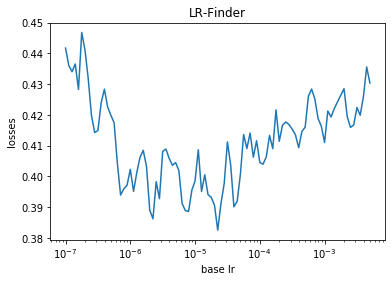

epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45098 - spearmanr 0.4167
best model: epoch -1 - 0.4167
epoch 0: 	 Start training...


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



epoch 0/5 	 train : loss 0.41137 - spearmanr 0.51577
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44971 - spearmanr 0.41972
best model: epoch 0 - 0.41972
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40929 - spearmanr 0.51879
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45003 - spearmanr 0.42025
best model: epoch 1 - 0.42025
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40866 - spearmanr 0.51989
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45028 - spearmanr 0.42019
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40757 - spearmanr 0.52233
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45075 - spearmanr 0.42012
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40692 - spearmanr 0.52369
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45085 - spearmanr 0.41997
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.42025
Starting inference for model: checkpoints/siamese_bert_6_fold_1_best.pth



Fold 2 started at Sun Jan 26 20:05:27 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45376 - spearmanr 0.4213
best model: epoch -1 - 0.4213
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40906 - spearmanr 0.51897
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45223 - spearmanr 0.4235
best model: epoch 0 - 0.4235
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40725 - spearmanr 0.52147
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45236 - spearmanr 0.42357
best model: epoch 1 - 0.42357
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40641 - spearmanr 0.52339
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.4525 - spearmanr 0.42338
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.4057 - spearmanr 0.52414
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45284 - spearmanr 0.42313
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40487 - spearmanr 0.52619
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45312 - spearmanr 0.42238
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.42357
Starting inference for model: checkpoints/siamese_bert_6_fold_2_best.pth



Fold 3 started at Sun Jan 26 20:07:33 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.46034 - spearmanr 0.39537
best model: epoch -1 - 0.39537
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40709 - spearmanr 0.52278
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45792 - spearmanr 0.39793
best model: epoch 0 - 0.39793
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40512 - spearmanr 0.5266
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.4578 - spearmanr 0.39869
best model: epoch 1 - 0.39869
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40455 - spearmanr 0.52787
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45809 - spearmanr 0.39869
best model: epoch 2 - 0.39869
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40383 - spearmanr 0.52939
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45842 - spearmanr 0.39836
model not improved for 1 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40294 - spearmanr 0.53131
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45839 - spearmanr 0.3983
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39869
Starting inference for model: checkpoints/siamese_bert_6_fold_3_best.pth



Fold 4 started at Sun Jan 26 20:09:34 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45619 - spearmanr 0.39697
best model: epoch -1 - 0.39697
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40832 - spearmanr 0.52141
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45429 - spearmanr 0.39766
best model: epoch 0 - 0.39766
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40659 - spearmanr 0.52453
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45479 - spearmanr 0.39752
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40591 - spearmanr 0.52542
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45485 - spearmanr 0.39759
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40513 - spearmanr 0.52753
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45529 - spearmanr 0.39728
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40451 - spearmanr 0.52847
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45541 - spearmanr 0.39698
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.39766
Starting inference for model: checkpoints/siamese_bert_6_fold_4_best.pth



Fold 5 started at Sun Jan 26 20:11:35 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45092 - spearmanr 0.40373
best model: epoch -1 - 0.40373
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.4088 - spearmanr 0.5195
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44937 - spearmanr 0.40558
best model: epoch 0 - 0.40558
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40725 - spearmanr 0.52267
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44975 - spearmanr 0.40592
best model: epoch 1 - 0.40592
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40604 - spearmanr 0.52548
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45003 - spearmanr 0.40564
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40533 - spearmanr 0.52708
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45038 - spearmanr 0.40561
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.4049 - spearmanr 0.52778
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45066 - spearmanr 0.40533
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.40592
Starting inference for model: checkpoints/siamese_bert_6_fold_5_best.pth



Fold 6 started at Sun Jan 26 20:13:35 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.4533 - spearmanr 0.39545
best model: epoch -1 - 0.39545
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.39907 - spearmanr 0.54272
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45225 - spearmanr 0.39573
best model: epoch 0 - 0.39573
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.39786 - spearmanr 0.54445
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45255 - spearmanr 0.39545
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39742 - spearmanr 0.5456
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45275 - spearmanr 0.395
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39701 - spearmanr 0.54626
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45297 - spearmanr 0.39493
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.3964 - spearmanr 0.54803
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45317 - spearmanr 0.39469
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.39573
Starting inference for model: checkpoints/siamese_bert_6_fold_6_best.pth



Fold 7 started at Sun Jan 26 20:15:36 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45672 - spearmanr 0.41321
best model: epoch -1 - 0.41321
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40785 - spearmanr 0.52138
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4555 - spearmanr 0.41529
best model: epoch 0 - 0.41529
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40612 - spearmanr 0.52478
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45561 - spearmanr 0.41564
best model: epoch 1 - 0.41564
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.405 - spearmanr 0.52682
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45603 - spearmanr 0.41521
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40443 - spearmanr 0.52827
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45633 - spearmanr 0.41504
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40371 - spearmanr 0.52942
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.4568 - spearmanr 0.41478
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.41564
Starting inference for model: checkpoints/siamese_bert_6_fold_7_best.pth



Fold 8 started at Sun Jan 26 20:17:35 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45964 - spearmanr 0.41748
best model: epoch -1 - 0.41748
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.4081 - spearmanr 0.52098
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.45849 - spearmanr 0.4183
best model: epoch 0 - 0.4183
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.40609 - spearmanr 0.52406
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.45903 - spearmanr 0.41848
best model: epoch 1 - 0.41848
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.40522 - spearmanr 0.52568
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45938 - spearmanr 0.41846
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.40465 - spearmanr 0.52636
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45954 - spearmanr 0.41837
model not improved for 2 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.40398 - spearmanr 0.52761
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.46001 - spearmanr 0.41836
model not improved for 3 epochs
TRAINING END: Best score achieved on epoch 1 - 0.41848
Starting inference for model: checkpoints/siamese_bert_6_fold_8_best.pth



Fold 9 started at Sun Jan 26 20:19:36 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.45694 - spearmanr 0.40566
best model: epoch -1 - 0.40566
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.39928 - spearmanr 0.53952
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.4557 - spearmanr 0.40568
best model: epoch 0 - 0.40568
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.3982 - spearmanr 0.54193
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.4559 - spearmanr 0.40534
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.39744 - spearmanr 0.54312
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.45601 - spearmanr 0.4053
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39688 - spearmanr 0.54504
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.45626 - spearmanr 0.40509
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.3964 - spearmanr 0.54577
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.45652 - spearmanr 0.40496
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.40568
Starting inference for model: checkpoints/siamese_bert_6_fold_9_best.pth



Fold 10 started at Sun Jan 26 20:21:37 2020
epoch -1: 	 Start validation...



epoch -1/5 	 valid : loss 0.44838 - spearmanr 0.4212
best model: epoch -1 - 0.4212
epoch 0: 	 Start training...



epoch 0/5 	 train : loss 0.40006 - spearmanr 0.53915
epoch 0: 	 Start validation...



epoch 0/5 	 valid : loss 0.44635 - spearmanr 0.42155
best model: epoch 0 - 0.42155
epoch 1: 	 Start training...



epoch 1/5 	 train : loss 0.39908 - spearmanr 0.54146
epoch 1: 	 Start validation...



epoch 1/5 	 valid : loss 0.44644 - spearmanr 0.4214
model not improved for 1 epochs
epoch 2: 	 Start training...



epoch 2/5 	 train : loss 0.3986 - spearmanr 0.54189
epoch 2: 	 Start validation...



epoch 2/5 	 valid : loss 0.44659 - spearmanr 0.42114
model not improved for 2 epochs
epoch 3: 	 Start training...



epoch 3/5 	 train : loss 0.39776 - spearmanr 0.54405
epoch 3: 	 Start validation...



epoch 3/5 	 valid : loss 0.44689 - spearmanr 0.42062
model not improved for 3 epochs
epoch 4: 	 Start training...



epoch 4/5 	 train : loss 0.39709 - spearmanr 0.5456
epoch 4: 	 Start validation...



epoch 4/5 	 valid : loss 0.44703 - spearmanr 0.42062
model not improved for 4 epochs
TRAINING END: Best score achieved on epoch 0 - 0.42155
Starting inference for model: checkpoints/siamese_bert_6_fold_10_best.pth



OOF score: 0.4111616187708672


In [13]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    
    output_file_path = lambda mode: f'{bert_output_dir}{mode}_{pretrained_model}_fold_{fold_id+1}'
    train_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('train')}_q_outputs.npy"),
                    np.load(f"{output_file_path('train')}_a_outputs.npy"), train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        BertDataset(cat_features_train, np.load(f"{output_file_path('valid')}_q_outputs.npy"),
                    np.load(f"{output_file_path('valid')}_a_outputs.npy"), valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = get_model(fold_id)
    
    if fold_id == 0:
        # print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-7, 
                             end_lr=1e-2, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=optim.lr_scheduler.StepLR(optimizer, n_epochs, 0.5), 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=False,
        eval_at_start=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
#     test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
#     preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [14]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

0 5 0.3644766327841672
0 10 0.3799960059488866
0 15 0.3812172588922937
0 20 0.3822696938097725
0 33 0.3839570517672923
0 100 0.384056529830416
0 200 0.3841348581547944
0 None 0.3842391945337892
1 5 0.6458715552778695
1 10 0.6608221543895012
1 15 0.6621619648739835
1 20 0.6641826145364094
1 100 0.6645245327106171
1 200 0.664567075540507
1 None 0.6645956867374525
2 5 0.48402631047582817
3 5 0.2846042384752419
3 10 0.29821808431313546
3 15 0.30152940408390067
3 20 0.30164291032581897
4 5 0.3612038764242704
5 5 0.458825783120487
6 5 0.3263878683395808
6 10 0.3542306342429258
6 15 0.3574517125507863
6 20 0.35777816768772697
7 5 0.5023737228166699
7 10 0.5097474558716162
7 15 0.510766964491097
7 20 0.5115442169130578
7 100 0.5124536250940648
7 200 0.5124936477132181
7 None 0.5125458954796486
8 5 0.5779092544073731
8 10 0.581602711447371
8 33 0.5821233550401959
9 5 0.04310947475141954
9 10 0.07725052147273995
9 15 0.12709028143129728
9 20 0.14965050125390716
10 5 0.4548416653338858
10 10 0.46

In [15]:
np.array(opt_ds), np.array(opt_indices)

(array([  5,  20,   5,   5,  20,  33,  20, 100,  10,   5,  15,   5,   5,
         10, 200,  15,  33, 100,  15,  20,  33,  10, 100]),
 array([ 2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20,
        21, 23, 24, 25, 26, 29]))

In [16]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [17]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.411162
CV unique rows,0.374133
CV ignoring hard targets,0.434647
CV unique rows ignoring hard targets,0.394743
CV w rounding,0.453135
CV unique rows w rounding,0.432655
CV ignoring hard targets w rounding,0.460728
CV unique rows ignoring hard targets w rounding,0.427664


In [18]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.415185
CV unique rows,0.378266
CV ignoring hard targets,0.434647
CV unique rows ignoring hard targets,0.394743
CV w rounding,0.453135
CV unique rows w rounding,0.432655
CV ignoring hard targets w rounding,0.460728
CV unique rows ignoring hard targets w rounding,0.427664


In [19]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [20]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
1,46,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
2,70,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
3,132,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
4,200,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001


In [21]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [22]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.765199,0.638948,0.215144,0.509555,0.547992,0.413433,0.567297,0.468837,0.487167,0.007139,0.742949,0.369517,0.409256,0.099742,0.015672,0.203991,0.244656,0.124040,0.596762,0.004345,0.763348,0.867883,0.554436,0.936865,0.902476,0.644847,0.104856,0.111996,0.919837,0.701601
1,0.838253,0.736817,0.034785,0.523255,0.895782,0.712483,0.484143,0.551812,0.288689,0.001045,0.295347,0.075988,0.825661,0.005361,0.545965,0.038028,0.050831,0.054495,0.461834,0.001969,0.751158,0.503374,0.277417,0.717460,0.731847,0.327400,0.028250,0.039237,0.570649,0.757134
2,0.609582,0.194051,0.007996,0.753801,0.773809,0.856493,0.504831,0.333571,0.232719,0.001636,0.344731,0.320595,0.007724,0.004893,0.001021,0.405131,0.646682,0.242867,0.126490,0.000110,0.496065,0.836404,0.582944,0.875603,0.869253,0.660260,0.594034,0.301866,0.445258,0.714579
3,0.780817,0.655621,0.459587,0.688207,0.614313,0.692743,0.602074,0.739563,0.201676,0.002386,0.476103,0.925867,0.017255,0.023340,0.020772,0.012064,0.027043,0.179508,0.519617,0.000967,0.822436,0.808188,0.804556,0.815479,0.917798,0.773410,0.070490,0.243100,0.836192,0.788627
4,0.751605,0.687130,0.002977,0.710202,0.829328,0.928459,0.468680,0.407894,0.171804,0.002241,0.279050,0.523870,0.001330,0.000745,0.001071,0.004396,0.847780,0.279998,0.172631,0.000105,0.757379,0.742998,0.414462,0.807184,0.903747,0.562314,0.942981,0.199297,0.026116,0.540415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.836161,0.290498,0.199130,0.802600,0.703372,0.679162,0.749579,0.744347,0.620015,0.002112,0.548431,0.916554,0.187357,0.143781,0.022478,0.153756,0.015687,0.031128,0.503334,0.002598,0.637410,0.857955,0.758921,0.931794,0.903193,0.690939,0.063954,0.081419,0.892234,0.667614
6075,0.888763,0.406887,0.140690,0.517040,0.405397,0.290706,0.770656,0.796613,0.050694,0.004164,0.826194,0.012066,0.006934,0.011369,0.000387,0.024880,0.817323,0.389648,0.207414,0.000097,0.757990,0.850389,0.610124,0.908940,0.938161,0.623423,0.792764,0.397616,0.378970,0.890540
6076,0.522716,0.236814,0.001756,0.700663,0.776602,0.910662,0.376976,0.241740,0.107960,0.001196,0.469117,0.359989,0.000531,0.000236,0.000253,0.001202,0.876622,0.394851,0.170818,0.000006,0.337489,0.386546,0.289715,0.649773,0.756004,0.258526,0.552253,0.153879,0.367832,0.161551
6077,0.806211,0.555729,0.683123,0.244910,0.295494,0.102296,0.534999,0.670059,0.794324,0.001268,0.922895,0.657607,0.266168,0.149594,0.005679,0.030679,0.036768,0.143133,0.785745,0.000147,0.853025,0.671860,0.477481,0.830460,0.817461,0.478015,0.025303,0.054388,0.869999,0.769012


In [23]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.384239
question_body_critical                   0.664596
question_conversational                  0.415644
question_expect_short_answer             0.300543
question_fact_seeking                    0.357956
question_has_commonly_accepted_answer    0.436273
question_interestingness_others          0.355578
question_interestingness_self            0.512546
question_multi_intent                    0.581420
question_not_really_a_question           0.097313
question_opinion_seeking                 0.469644
question_type_choice                     0.739075
question_type_compare                    0.356979
question_type_consequence                0.178813
question_type_definition                 0.362974
question_type_entity                     0.445994
question_type_instructions               0.777529
question_type_procedure                  0.353409
question_type_reason_explanation         0.665312
question_type_spelling                   0.067407


In [24]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.067407,3.0
question_not_really_a_question,0.097313,5.0
answer_plausible,0.133202,9.0
answer_relevance,0.164131,9.0
question_type_consequence,0.178813,5.0
answer_well_written,0.232273,9.0
answer_helpful,0.235343,9.0
question_expect_short_answer,0.300543,5.0
answer_type_procedure,0.304365,5.0
answer_satisfaction,0.332763,17.0


In [25]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

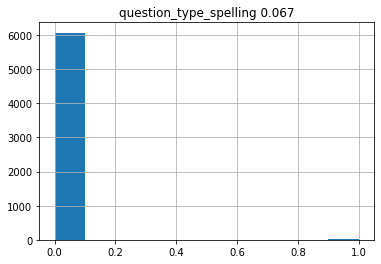

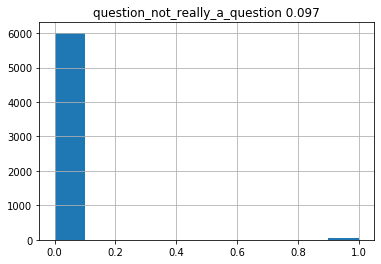

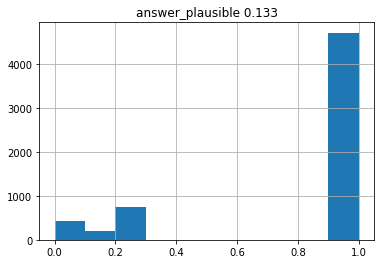

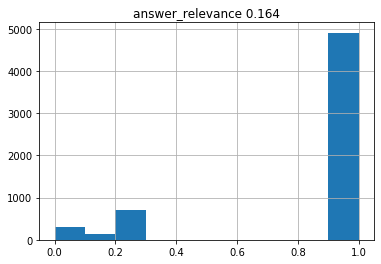

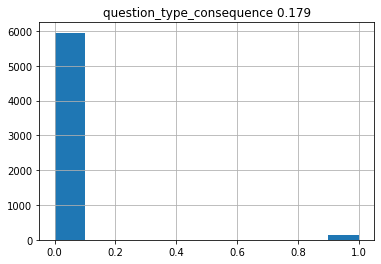

In [26]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


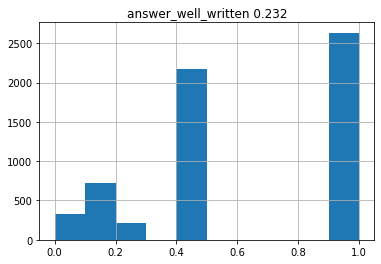

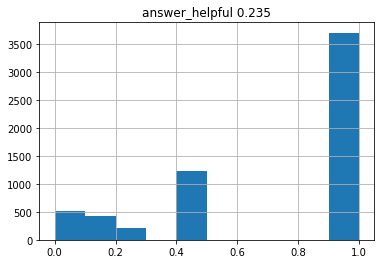

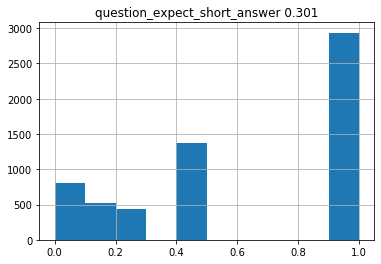

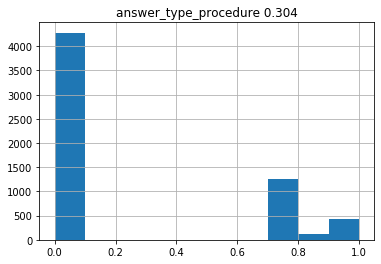

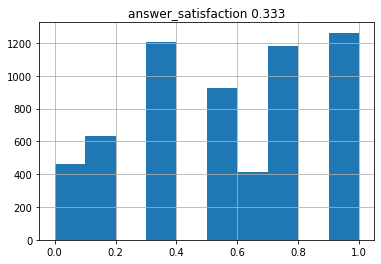

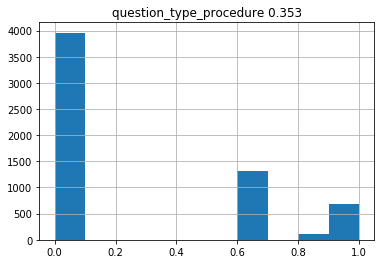

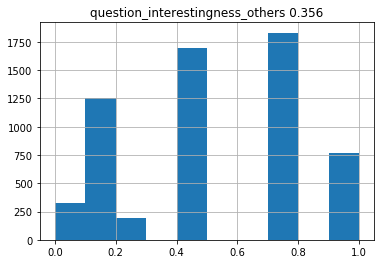

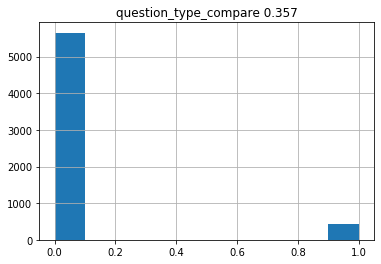

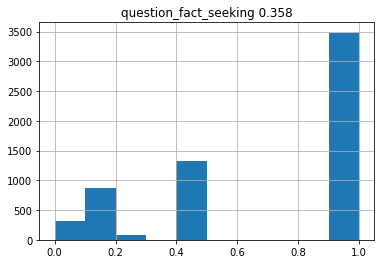

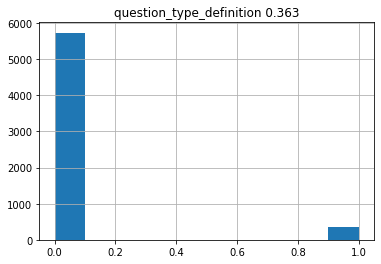

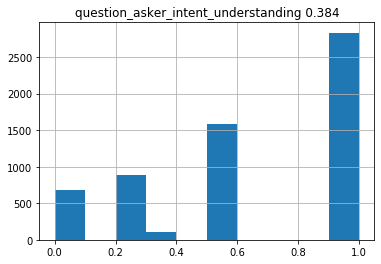

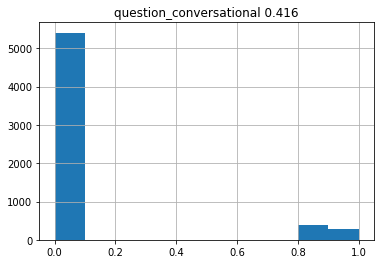

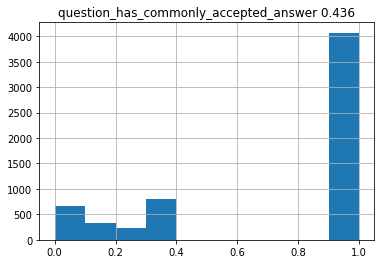

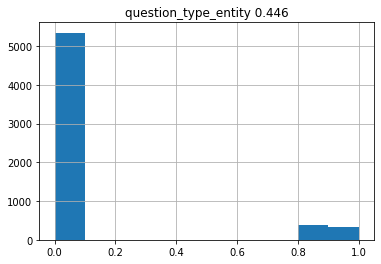

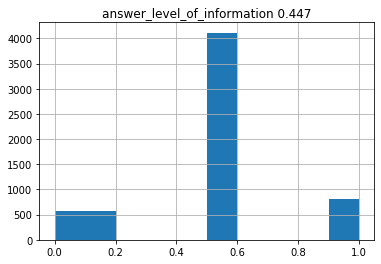

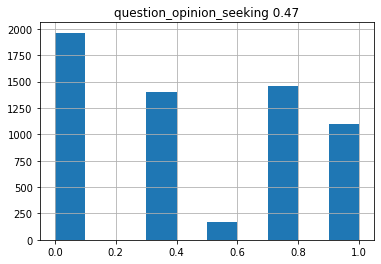

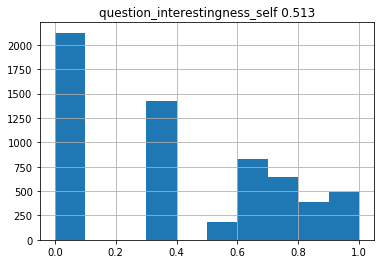

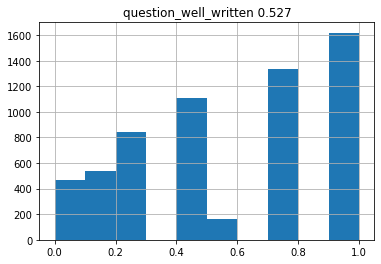

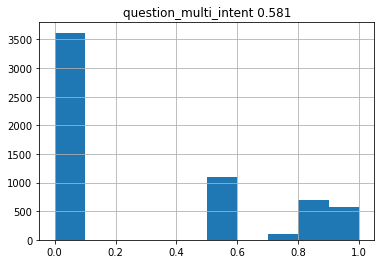

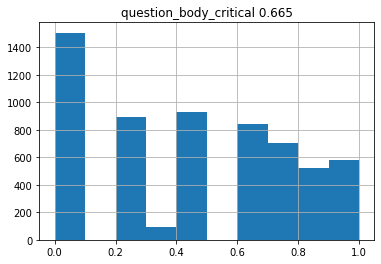

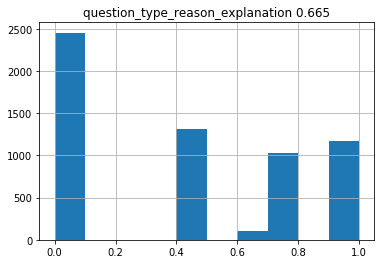

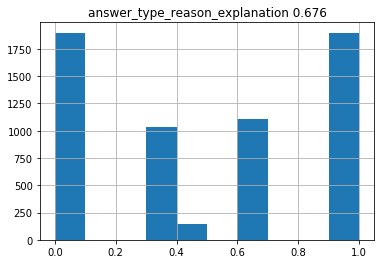

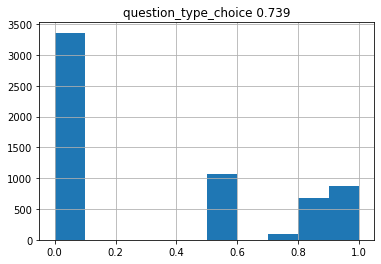

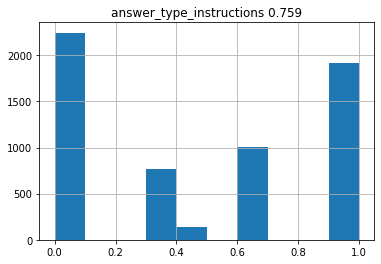

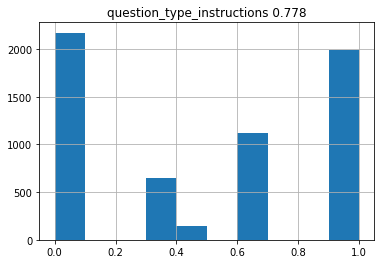

In [27]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')